## 1 - Exploration and discovery of the base case ##

In this notebook, we explore and discover the outcomes of the 'base case' scenario; the base case is defined as the 'doing nothing policy' which results in a policy in which all policy levers are set to zero. This exploration is done to explore the uncertainty space and get a quick overview of how our KPI's behave. 

Afterwards, the worst scenario's for our KPI's have been selected and analysed. Following from this analysis, we can define the uncertainty-ranges the model will act most worse in. Later on, these uncertainties will be given extra attention when finding the most robust policies.

For our experiments we will use the latin hypercube sampling (LHS) to generate the points in the parameter space defined by the uncertainties and 'base case' policy. 

In [1]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Import workbench libraries and the model itself
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

from dike_model.problem_formulation import get_model_for_problem_formulation
from dike_model.dike_model_function import DikeNetwork 

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Here we define the problem formulation. For our analysis, we pick problem formulation 5, since pf 5 results in the most disaggregate form of the outcomes. Later on we aggregate the outcomes in the KPIs that are of most use to us.

In [2]:
# Instantiate the problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(5)

def sum_over(*args):
    return sum(args)

First we run a base exploration, with all policy levers set to zero. We chose to run for 5000 scenario's, as this will give an broad overview in which the full uncertainty space is more or less covered (relatively seen).

Some code is commented out, because it was run and afterwards saved to e.g. a CSV-file.

In [3]:
# Define the base case policy, which sets all the levers that are present within the dike_model to zero.
policy_basecase = [Policy("base case", **{lever.name: 0 for lever in dike_model.levers})]

#Running the experiments (commented out)
# with MultiprocessingEvaluator(dike_model, n_processes = 8) as evaluator:
#     results = evaluator.perform_experiments(scenarios=5000, policies=policies)

# utilities.save_results(results, 'results/5000ScenariosNoPolicyPF5.csv')
# experiments, outcomes = results

# Load in the results from the CSV we had saved from running the experiments
results = utilities.load_results('results/5000ScenariosNoPolicyPF5.csv')
experiments, outcomes = results

# We create a 'combined' dataframe, in which the experiments and outcomes are merged within one pandas dataframe.
df_outcomes = pd.DataFrame(outcomes)
combined = pd.concat([experiments,df_outcomes],axis=1,sort=False)

combined.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\marce\Desktop\MBDM Project\results\5000ScenariosNoPolicyPF5.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,50.0,261.078733,10.0,0.918584,242.097427,1.5,0.782808,323.090209,10.0,0.014383,...,0,1.216039,0.000000e+00,0,0.000000,0.000000e+00,0,0.0000,0.0,0.0
1,115.0,102.575508,1.5,0.013521,235.516408,1.0,0.211856,331.286100,10.0,0.369912,...,0,0.026562,3.648962e+06,0,0.001557,0.000000e+00,0,0.0000,0.0,0.0
2,102.0,70.372003,10.0,0.412962,285.823933,1.0,0.756799,224.721909,1.0,0.836067,...,0,0.000000,2.499073e+06,0,0.000926,2.842712e+08,0,0.1851,0.0,0.0
3,78.0,233.293698,1.5,0.363073,94.728242,1.0,0.056205,191.755429,10.0,0.286753,...,0,0.006627,0.000000e+00,0,0.000000,0.000000e+00,0,0.0000,0.0,0.0
4,81.0,237.526187,1.5,0.012442,251.539206,1.0,0.492985,136.420228,10.0,0.365359,...,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.0000,0.0,0.0


### Visualization of the retrieved outcomes ###

In order to acquire information from the experiment performed earlier, we visualize the retrieved data in a form that is readable and ready to communicate with our problem owner. 

To do so, we aggregated the outcomes from problem formulation 5 into our relevant KPIs. The following KPIs are considered: 
 - Expected number of deaths (total and per location)
 - Expected annual damage (total and per location)
 - The variance of the annual damage between locations (how are the costs distributed?)
 
Since the 'base case' policy does not consider any investment in the dikes, all of the costs-outcomes are zero and, therefore, are not taken into account within this visualization or further analysis for the base case.

In [4]:
# The following function is used to aggregate the outcomes into the KPI we want
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
def aggregate_kpi(data, kpi, aggregate):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    kpi_columns = []
    
    if kpi == "RfR Total Costs" or kpi == "Expected Evacuation Costs":
        kpi_columns.append(kpi + " 0")
        kpi_columns.append(kpi + " 1")
        kpi_columns.append(kpi + " 2")
        
        data[kpi] = data[kpi_columns].sum(axis=1)
    else:
        if aggregate is "total":
            for location in locations:
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

            data[kpi] = data[kpi_columns].sum(axis=1)

        else:
            for location in locations:
                kpi_columns = []
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

                data[location + "_" + kpi] = data[kpi_columns].sum(axis=1)
                
    return data

# Append the KPIs we would like to analyse. The RfR total costs and expected evacuation costs are included for later on in the analysis, but are not used for the base case analysis, as they are still 0.
combined = aggregate_kpi(combined, "Expected Number of Deaths", "location")
combined = aggregate_kpi(combined, "Expected Number of Deaths", "total")
combined = aggregate_kpi(combined, "Expected Annual Damage", "location")
combined = aggregate_kpi(combined, "Expected Annual Damage", "total")
combined = aggregate_kpi(combined, "RfR Total Costs", "total")
combined = aggregate_kpi(combined, "Expected Evacuation Costs", "total")

First of all, the locations are to be analysed with the means of a violin-plot. The violin-plot indicates the distribution of the outcomes, i.e. the width indicates the frequency of outcomes in that particular range. 

**Expected number of deaths per location**

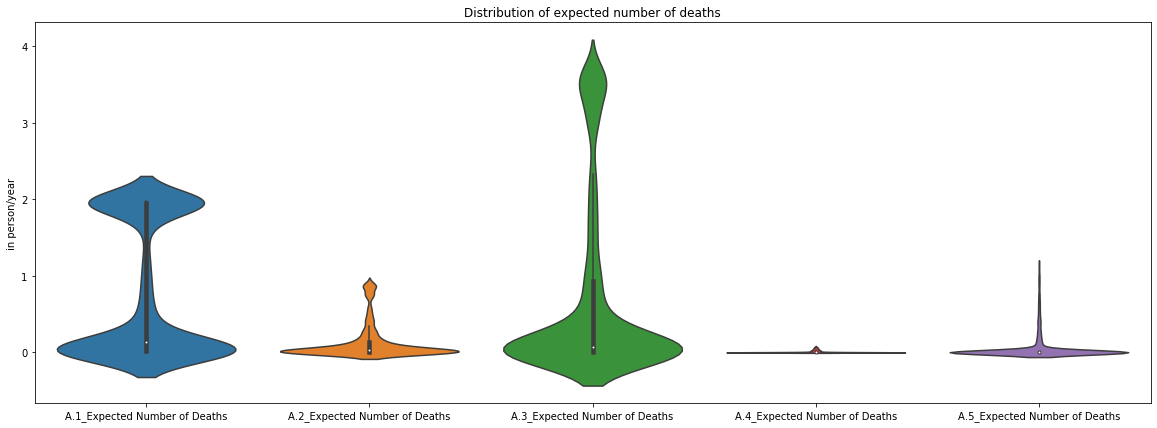

In [5]:
plt.figure(figsize=(20,7))
plt.title("Distribution of expected number of deaths")
plt.ylabel("in person/year")
ax = sns.violinplot(data=combined.loc[:, ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]], scale='count')
plt.show()

**Expected annual damage per location**

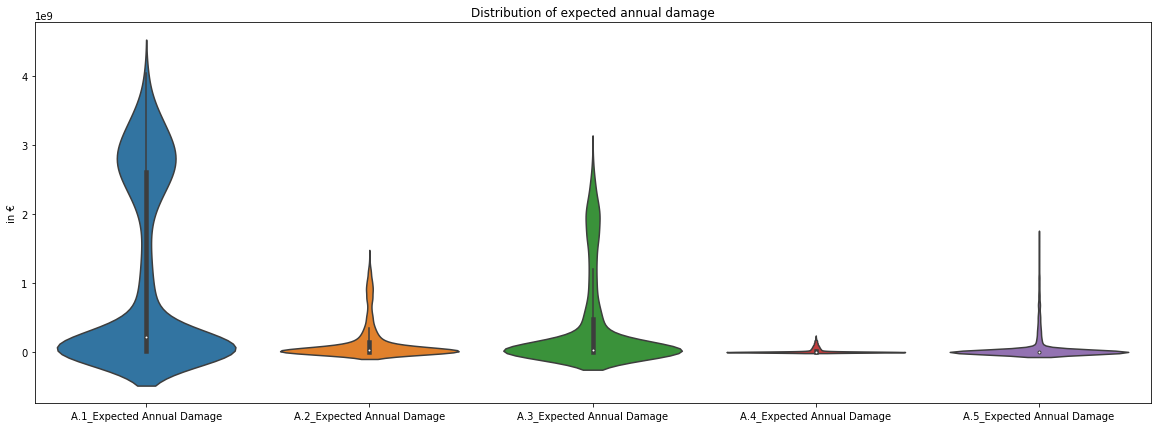

In [6]:
plt.figure(figsize=(20,7))
plt.title("Distribution of expected annual damage")
plt.ylabel("in €")
ax = sns.violinplot(data=combined.loc[:, ["A.1_Expected Annual Damage","A.2_Expected Annual Damage","A.3_Expected Annual Damage","A.4_Expected Annual Damage","A.5_Expected Annual Damage"]], scale='count')
plt.show()

As can be seen in the figures above, location A1 and A3 suffers the most in the 'base case' policy scenarios. The 'expected number of deaths' and the 'expected annual damage' is in those locations the highest of all 5. Also, it can be noted that within these locations the amount of outliers are higher comparing to the other 3 locations.

**Variance of expected annual damage per location**

In order to visualize whether the costs are distributed evenly over the locations (i.e., location A1 does not run for all costs), the variance between the location per scenario is calculated and visualized.

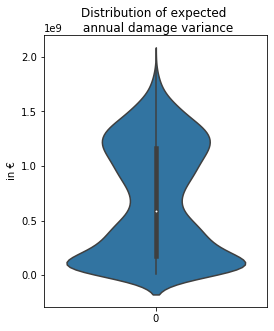

In [7]:
def variance_kpi(data, kpi):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    kpi_columns = []
    
    for location in locations:
        kpi_columns.append(location + "_" + kpi)
                    
    data["Variance " + kpi] = data[kpi_columns].std(axis=1)
    
    return data

combined = variance_kpi(combined, "Expected Annual Damage")

plt.figure(figsize=(4,5))
plt.title("Distribution of expected \n annual damage variance", pad=0)
plt.ylabel("in €")
sns.violinplot( data=combined.loc[:, "Variance Expected Annual Damage"], scale='count')

plt.show()

As can be seen, in some scenarios the costs are evenly distributed (bottom of the violion plot). However, in around 50% of the scenario's, the costs are not evenly distributed (a standard deviation of more than €1 * e9). This also elaborates on the fact that location A1 and A3 suffer the most concluding from the plots per location.

**Aggregated results**

Lastly, we look at the aggregated results, we will visualize this with the violin-plot introduced before and with a histogram plot. While these plots will give a clear overview of the fact that the outcomes are quite distributed, and therefore policy is needed, these plots are not included in the report, as the message it conveys is similar to that of the previous plots. While some variation in costs is probably not fully inevitable, deaths are however unacceptable and therefore, policy must be introduced to get this number to zero.

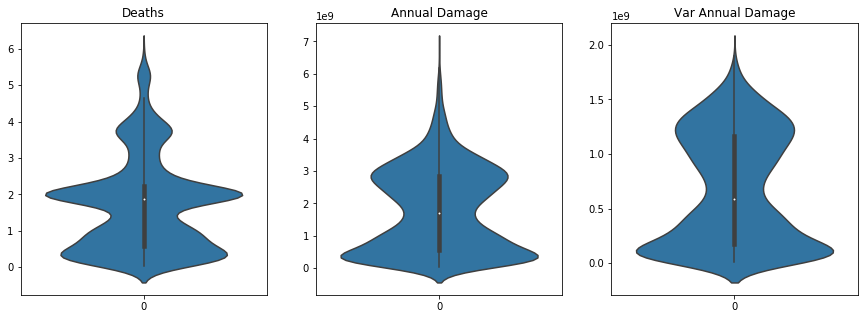

In [8]:
f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.violinplot(data=combined.loc[:, "Expected Number of Deaths"], scale='count', ax=axes[0])
sns.violinplot(data=combined.loc[:, "Expected Annual Damage"], scale='count', ax=axes[1])
sns.violinplot(data=combined.loc[:, "Variance Expected Annual Damage"], scale='count', ax=axes[2])

axes[0].set_title("Deaths")
axes[1].set_title("Annual Damage")
axes[2].set_title("Var Annual Damage")

plt.show()

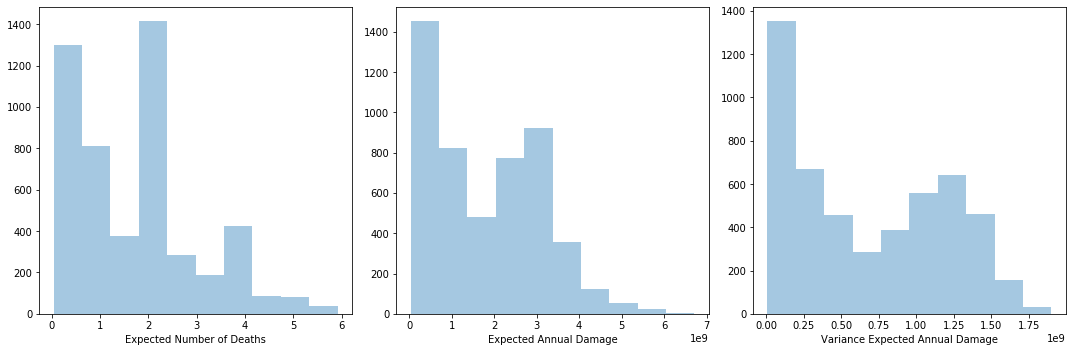

In [9]:
f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.distplot(combined["Expected Number of Deaths"], bins=10, kde=False, ax=axes[0])
sns.distplot(combined["Expected Annual Damage"], kde=False, bins=10, ax=axes[1])
sns.distplot(combined["Variance Expected Annual Damage"], bins=10, kde=False, ax=axes[2])
plt.tight_layout()
plt.show()

The above visualizations shows us that there really is a need for policy. The deaths are in most of the scenario's quite high  (which should be prevented). Furthermore, the damage could also be reduced. Lastly, the variance between the locations is too high for a lot of the scenarios, and as Rijkswaterstaat would prefer to equal this out more, policy would be effective. 

### Scenario discovery ###

By executing a scenario discovery analysis, we are planning to find uncertain futures where the resulting values are undesirable, given that no policy is implemented yet. 

To find scenarios in which these outcomes perform poorly, the Patient Rule Induction Method (PRIM) is used, which is incorporated in the EMA workbench. Originally designed by Friedman & Fisher (1999), PRIM is a technique that iteratively narrows down the uncertainty space until boxes are found that form a good trade-off between coverage (what fraction of the total outcomes of interest are in the box) and density (what fraction of all cases in the box are actually of interest).

**Undesirability**

Undesirability is in this case defined as being in the 66.6th percentile of outcomes, meaning that scenarios in which deaths, damage and variance of damage between locations are all in the upper 33.3% of their range are sought.  

**Results**

From the PRIM follows that 879 scenarios are of interest within the scenario space of 5000 (=17.5%). These 879 scenarios can be mainly credited to four uncertainties. The uncertainty ranges that creates the worst scenarios are the following:

- A.1_pfail between 0 and 0.34
- A.2_pfail between 0 and 0.96
- A.3_pfail between 0 and 0.91
- A.1_Bmax between 0 and 190

[MainProcess/INFO] 5000 points remaining, containing 879 cases of interest
[MainProcess/INFO] mean: 0.8745247148288974, mass: 0.0526, coverage: 0.2616609783845279, density: 0.8745247148288974 restricted_dimensions: 5


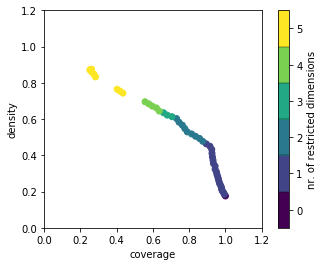

In [10]:
from ema_workbench.analysis import prim

# Select the uncertainty values
cleaned_experiments = combined.iloc[:,:19]

# Calculate the value (threshold) where the upper 33.3% range starts
percentile_costs = np.percentile(combined["Expected Annual Damage"], 66)
percentile_deaths = np.percentile(combined["Expected Number of Deaths"], 66)
percentile_var = np.percentile(combined["Variance Expected Annual Damage"], 66)

# Bool the values if they are larger than the threshold
combined["Cost_bool"] = combined["Expected Annual Damage"] > percentile_costs
combined["Death_bool"] = combined["Expected Number of Deaths"] > percentile_deaths
combined["Var_bool"] = combined["Variance Expected Annual Damage"] > percentile_var

# If cost and deaths and variance arein the 66th upper percentiles indicate true
y = combined["Cost_bool"] & combined["Death_bool"] & combined["Var_bool"]

# Execute prim algorithm
prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.6)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
plt.show()

It is important that a good box is selected, that properly trades off density and coverage. Whereas ideally, the density should be around 0.8, this would in this case lead to a coverage of less than 0.3. Therefore, a box has been chosen with a slightly lower density of 0.696, so that coverage is still somewhat representative. The fact that this includes 4 dimensions instead of 5 might be too limiting, but it does make interpretation easier. 

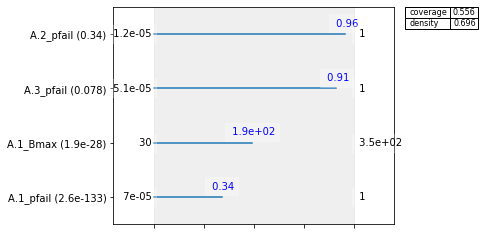

In [11]:
# Choosing the best box and inspecting the corresponding coverage, density and uncertainty ranges.
box1.inspect(38, style='graph')
box1.select(38)
plt.show()

The tradeoffs can be plotted using dimensional stacking and through a matrix of scatter plots. For the report, the latter was chosen, because it feels more easily interpretable in this case. 

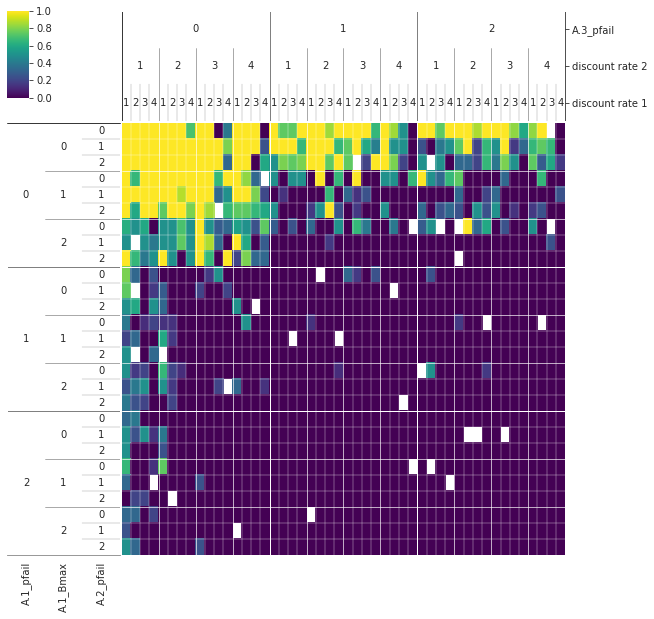

In [12]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y, nr_levels=3)
plt.show()

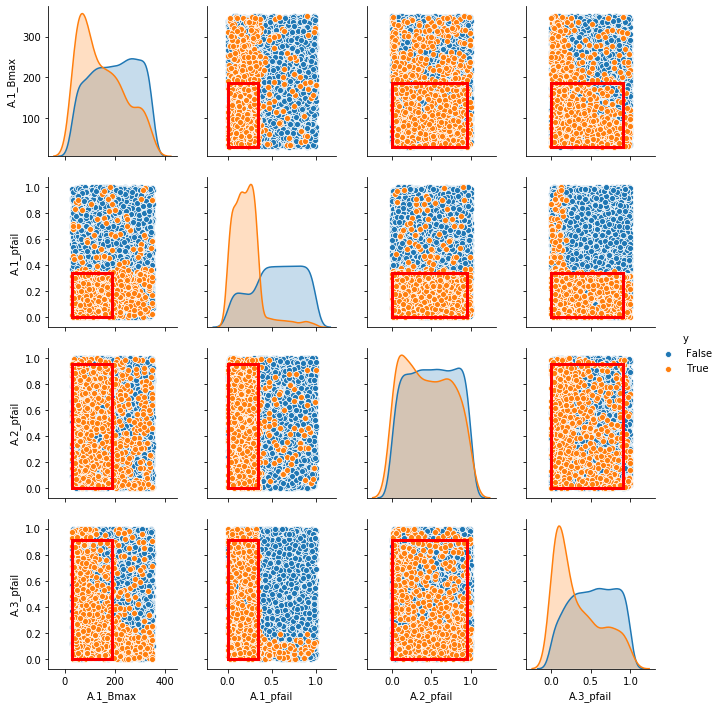

In [13]:
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.savefig("images/PRIM_results_distributionmatrix.png")
plt.show()

This finalizes the exploration section of this analysis, which are fully reported and interpreted in section 4.1 and 4.2 of the main report.